Marta Xiulan Aribó Herrera and German Anashkin

Data Driven Social Analytics - Assignment II

MIIS 2025

---



# Installs and Libraries

In [4]:
import pandas as pd
import snap
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import datetime
import os
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import powerlaw

In [5]:
sns.set_context("paper")

# Download Data (Do not run)

In [55]:
!wget http://www.sociopatterns.org/files/datasets/004/sg_infectious_contact_list.tgz

--2025-01-29 21:45:36--  http://www.sociopatterns.org/files/datasets/004/sg_infectious_contact_list.tgz
S'està resolent www.sociopatterns.org (www.sociopatterns.org)… 95.174.14.229, 2001:4b78:2100::151:1
S'està connectant a www.sociopatterns.org (www.sociopatterns.org)|95.174.14.229|:80… conectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 200 OK
Mida: 1425682 (1,4M) [application/x-gzip]
S'està desant a: ‘sg_infectious_contact_list.tgz’

sg_infectious_conta 100%[===================>]   1,36M   302KB/s    in 6,2s    

2025-01-29 21:45:43 (223 KB/s) - s'ha desat ‘sg_infectious_contact_list.tgz’ [1425682/1425682]



In [ ]:
!mkdir -p ../sociopatterns
!tar -xzf sg_infectious_contact_list.tgz -C ../sociopatterns
!ls ../sociopatterns

In [80]:

dataset = pd.DataFrame()
read_path = "../sociopatterns/"
save_path = "../data/"
for file in os.listdir(read_path):
  file = read_path + file
  df = pd.read_csv(file, delimiter='\t')
  df.columns = ['contact_time', 'user_1', 'user_2']
  dataset = pd.concat([dataset, df])

dataset.to_csv(save_path+"infectious_data.csv", index=False)

# Load Dataset

In [6]:
path = "../data/infectious_data.csv"
df = pd.read_csv(path)

df['contact_time'] = df['contact_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))


# 1. Dataset Analysis

## a. General Characteristics of the Dataset

[DATASET LINK:  Infectious SocioPatterns dynamic contact networks ](href="http://www.sociopatterns.org/datasets/infectious-sociopatterns-dynamic-contact-networks/")

This dataset records face-to-face interactions between individuals overt time. It is structure into three columns: *user_1*, *user_2* and *contact_time*. Each row represents a recorded contact event between two individuals at a specific time. These names have been labeled by us for better understanding.

* *user_1* and *user_2* : Unique and anonymous identifiers assigned to individuals involved in a contact event.
* *contact_time* :  A timestamp representing the time interval [t-20s, t] during which the two individuals were in contact. The time is expressed in UNIX ctime format.

The dataset have shape of 415843 x 3

In [7]:
df.head()

,contact_time,user_1,user_2
0,2009-06-04 12:19:19,90505314,78184522
1,2009-06-04 12:19:19,90505314,78446676
2,2009-06-04 12:19:19,90505314,78577729
3,2009-06-04 12:19:19,78184522,75104339
4,2009-06-04 12:19:19,78446676,74973244


In [8]:
G = snap.TUNGraph.New()

for idx, row in tqdm(df.iterrows(), total=len(df)):
    if not G.IsNode(row['user_1']):
        G.AddNode(row['user_1'])

    if not G.IsNode(row['user_2']):
        G.AddNode(row['user_2'])

    G.AddEdge(row['user_1'], row['user_2'])

G.PrintInfo()

100%|██████████| 415843/415843 [00:28<00:00, 14850.99it/s]

Graph:
  Nodes:                    10972
  Edges:                    44516
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         0
  Zero OutDeg Nodes:        0
  NonZero In-Out Deg Nodes: 10972


In [9]:
def get_general_characteristics(G):
    nodes_degree = [G.GetDegreeCentr(node.GetId()) for node in G.Nodes()]
    string = f"""   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : {G.GetNodes()}
    Number of edges     : {G.GetEdges()}
    Density             : {G.GetNodes()/G.GetEdges()}
    Average Degree      : {np.mean(nodes_degree)}
    Median Degree       : {np.median(nodes_degree)}
    Max Degree          : {np.max(nodes_degree)}
    Min Degree          : {np.min(nodes_degree)}
    ---------------------------------------------------
    """

    return string

res = get_general_characteristics(G)
print(res)

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.24647317818312517
    Average Degree      : 0.0007396293140571141
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    


## b. Node Centrality
Refers to the importance of a node given a graph, how central is the node related to the network. We are going to be measuring this metric using at least three different methods. [Snap doc.](href="https://snap.stanford.edu/snappy/doc/reference/centr.html")

### Degree Centrality ([GetDegreeCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetDegreeCentr.html))
A graph method for undirected graphs that returns degree centrality of a given node NId. Degree centrality of a node is defined as its degree/(N-1), where N is the number of nodes in the graph.

In [10]:
def get_degree_centrality(G):
    degree_centrality = {}
    for node in G.Nodes():
        degree_centrality[node.GetId()] = G.GetDegreeCentr(node.GetId())

    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_degree_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has degree centrality of {centrality}. It has {count_contact_time} contacts.
        """        
        # nx_graph = nx.Graph()
        # nx_graph.add_node(node)

        # NI = G.GetNI(node)

        # for i in range(NI.GetDeg()):
        #     neighbor = NI.GetNbrNId(i)
        #     nx_graph.add_node(neighbor)
        #     nx_graph.add_edge(node, neighbor)
        
        # plt.figure(figsize=(5, 5))
        # nx.draw(nx_graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1000, font_size=12)
        # plt.title(f"Visitor (Node) {node}")
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_degree_centrality(G)  
print(res)


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.005833561206817974. It has 570 contacts.
        
    Visitor (Node) 90636462 has degree centrality of 0.004557469692826542. It has 267 contacts.
        
    Visitor (Node) 94961689 has degree centrality of 0.004375170905113481. It has 129 contacts.
        
    Visitor (Node) 81068077 has degree centrality of 0.00428402151125695. It has 123 contacts.
        
    Visitor (Node) 80150715 has degree centrality of 0.0041928721174004195. It has 415 contacts.
        
    ---------------------------------------------------
    


### Closeness Centrality ([GetClosenessCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetClosenessCentr.html))
A graph method that returns closeness centrality of a given node NId. Closeness centrality is equal to 1/farness centrality.

In [11]:
def get_closeness_centrality(G):
    closeness_centrality = {}
    for node in G.Nodes():
        closeness_centrality[node.GetId()] = snap.GetClosenessCentr(G, node.GetId())

    sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_closeness_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has closeness centrality of {centrality}. It has {count_contact_time} contacts.
        """        
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_closeness_centrality(G)
print(res)

   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 77070363 has closeness centrality of 0.015495489587108066. It has 110 contacts.
        
    Visitor (Node) 90636462 has closeness centrality of 0.01496325981718777. It has 267 contacts.
        
    Visitor (Node) 73597118 has closeness centrality of 0.01411811273492068. It has 140 contacts.
        
    Visitor (Node) 89587733 has closeness centrality of 0.013975766960324784. It has 249 contacts.
        
    Visitor (Node) 102629386 has closeness centrality of 0.013761337322846876. It has 89 contacts.
        
    ---------------------------------------------------
    


### Farness Centrality ([GetFarnessCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetFarnessCentr.html))
A graph method that returns farness centrality of a given node NId. Farness centrality of a node is the average shortest path length to all other nodes that reside in the same connected component as the given node.

In [12]:
def get_farness_centrality(G):
    farness_centrality = {}
    for node in G.Nodes():
        farness_centrality[node.GetId()] = snap.GetFarnessCentr(G, node.GetId())

    sorted_farness_centrality = sorted(farness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_farness_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has farness centrality of {centrality}. It has {count_contact_time} contacts.
        """        
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_farness_centrality(G)
print(res)

   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 101843033 has farness centrality of 10971.0. It has 66 contacts.
        
    Visitor (Node) 98304080 has farness centrality of 10971.0. It has 66 contacts.
        
    Visitor (Node) 78577731 has farness centrality of 10971.0. It has 32 contacts.
        
    Visitor (Node) 96403528 has farness centrality of 10971.0. It has 32 contacts.
        
    Visitor (Node) 78118988 has farness centrality of 10971.0. It has 27 contacts.
        
    ---------------------------------------------------
    


### Eigenvector Centrality ([GetEigenVectorCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetEigenVectorCentr.html))
A graph method for undirected graphs that returns eigenvector centrality of all nodes. Eigenvector Centrality of a node N is defined recursively as the average of centrality values of N’s neighbors in the network.

In [13]:
def get_eigenvector_centrality(G):
    eigenvector_centrality = {}
    NIdEigenH = G.GetEigenVectorCentr()

    for node in NIdEigenH:
        eigenvector_centrality[node] = NIdEigenH[node]

    sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
    string = f"""
    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_eigenvector_centrality[:5]):
        count_contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].count()
        string += f"""
    Visitor (Node) {node} has degree centrality of {centrality}. It has {count_contact_time} contacts.
        """

    string += f"""
    ---------------------------------------------------
    """
    return string

res = get_eigenvector_centrality(G)
print(res)


    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 78905411 has degree centrality of 0.20754608168233502. It has 117 contacts.
        
    Visitor (Node) 73400401 has degree centrality of 0.2018681719733262. It has 154 contacts.
        
    Visitor (Node) 104529997 has degree centrality of 0.19811100520382696. It has 183 contacts.
        
    Visitor (Node) 78839891 has degree centrality of 0.19623933122293846. It has 119 contacts.
        
    Visitor (Node) 100991066 has degree centrality of 0.18710519098311235. It has 119 contacts.
        
    ---------------------------------------------------
    


## c. Average path length, diameter, effective diameter

In [14]:
def get_path_length_diameter(G):
    res = G.GetBfsEffDiamAll(10, False)
    eff_diameter = (res[0], res[1])
    diameter = res[2]
    avg_shortest_path = res[3]

    string = f"""   
    ---------------------------------------------------
    Average Path Length : {avg_shortest_path}
    Diameter            : {diameter}
    Effective Diameter  : {eff_diameter}
    ---------------------------------------------------
    """

    return string

res = get_path_length_diameter(G)
print(res)

   
    ---------------------------------------------------
    Average Path Length : 4.645616641901932
    Diameter            : 14
    Effective Diameter  : (7.475757575757577, 7.475757575757577)
    ---------------------------------------------------
    


## d. The innermost k-shell

Using the methods GetKCore, GetKCoreNodes and GetKCoreEdges (doc [here](href:https://snap.stanford.edu/snappy/doc/reference/kcore.html?highlight=core))

In [15]:
def get_innermos_k_shell(G):
    max_k_val, order_k_nodes= G.GetKCoreNodes()
    num_nodes_per_k = [(item.GetVal1(), item.GetVal2()) for item in order_k_nodes]

    max_k_val, order_k_edges= G.GetKCoreEdges()
    num_edges_per_k = [(item.GetVal1(), item.GetVal2()) for item in order_k_edges]

    string = f"""   
    ---------------------------------------------------
    Innermost k-shell : {max_k_val-1}
    Number of nodes   : {num_nodes_per_k[-1][1]}
    Number of edges   : {num_edges_per_k[-1][1]}
    ---------------------------------------------------
    """

    return string

res = get_innermos_k_shell(G)
print(res)

   
    ---------------------------------------------------
    Innermost k-shell : 18
    Number of nodes   : 55
    Number of edges   : 595
    ---------------------------------------------------
    


## e. The clustering coefficient [GetClustCf()](href:https://snap.stanford.edu/snappy/doc/reference/GetClustCf.html?highlight=clustering%20coefficient)
A graph method that computes the average clustering coefficient as defined in Watts and Strogatz, Collective dynamics of ‘small-world’ networks.  Is a measure of the degree to which nodes in a graph tend to cluster together

In [16]:
def get_cluster_coeff(G):
    cluster_coeff = snap.GetClustCf(G)
    string = f"""
    ---------------------------------------------------
    Clustering Coefficient : {cluster_coeff}
    ---------------------------------------------------
    """
    return string

res = get_cluster_coeff(G)
print(res)


    ---------------------------------------------------
    Clustering Coefficient : 0.44667305638379806
    ---------------------------------------------------
    


# 2. Degree distribution

First we calculate the degree distribution (number of interactions vs how many users have this amount of interactions), and then we perform a power-law fit using the library powerlaw. If we look at the empirical data, we see that it does not have a pure power-law distribition, but it has a peak at degree = 3. Therefore, we set in the parameter xmin which will set a threshold from which there is a power-law behavior. 

In [17]:
Gr = nx.Graph()

for _, row in df.iterrows():
    Gr.add_edge(row['user_1'], row['user_2'])


degree_sequence = [Gr.degree(user) for user in Gr.nodes]

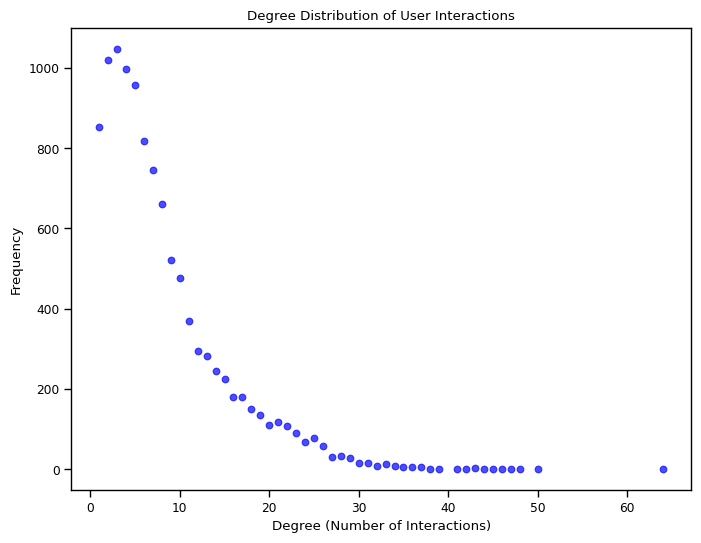

In [18]:
# Count frequency of each degree
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1

# Prepare data for plotting (degree vs frequency)
degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

# Plot the degree distribution as points
plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7)
plt.title('Degree Distribution of User Interactions')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.show()

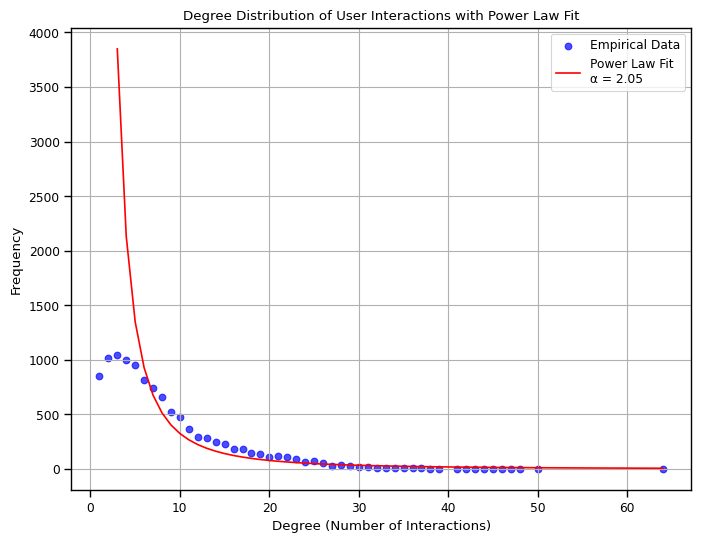

In [19]:
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1


degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

fit = powerlaw.Fit(degree_sequence, xmin=3)  

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin


xmin_int = int(np.floor(xmin))  
x_range = range(xmin_int, max(degrees) + 1)


y_range = [fit.power_law.pdf(x) * len(degree_sequence) for x in x_range]


plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7, label='Empirical Data')

plt.plot(x_range, y_range, color='r', label=f'Power Law Fit\nα = {alpha:.2f}')

plt.title('Degree Distribution of User Interactions with Power Law Fit')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 3. Network Comparison

## [Preferential Attachment Network](ref:https://snap.stanford.edu/snappy/doc/reference/GenGeoPrefAttach.html?highlight=pref)

In [20]:
num_nodes = G.GetNodes()
num_edges = G.GetEdges()

random = snap.TRnd(42)

In [21]:
G_pref_attach = snap.GenGeoPrefAttach(num_nodes, num_edges, 0.25, random)

res_pref_attach = get_general_characteristics(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_degree_centrality(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_closeness_centrality(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_farness_centrality(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_eigenvector_centrality(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_path_length_diameter(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_innermos_k_shell(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_cluster_coeff(G_pref_attach)
print(res_pref_attach)


   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 5038819
    Density             : 0.0021774943692162785
    Average Degree      : 0.08371952198373515
    Median Degree       : 0.08376629295415186
    Max Degree          : 0.09060249749339166
    Min Degree          : 0.07492480175006837
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 6608 has degree centrality of 0.09060249749339166. It has 0 contacts.
       

KeyboardInterrupt: 

In [22]:
G_pref_attach = snap.GenGeoPrefAttach(num_nodes, num_edges, 0.25, random)

degree_sequence = []
for NI in G_pref_attach.Nodes():
    degree_sequence.append(NI.GetDeg())

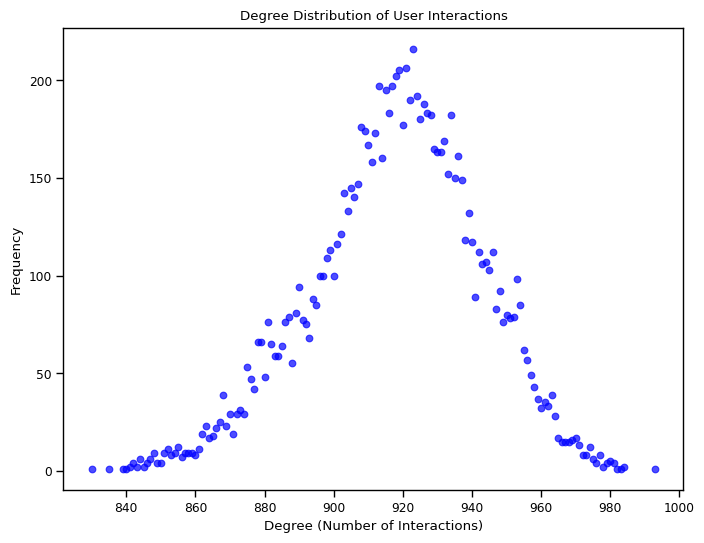

In [23]:
# Count frequency of each degree
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1

# Prepare data for plotting (degree vs frequency)
degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

# Plot the degree distribution as points
plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7)
plt.title('Degree Distribution of User Interactions')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.show()

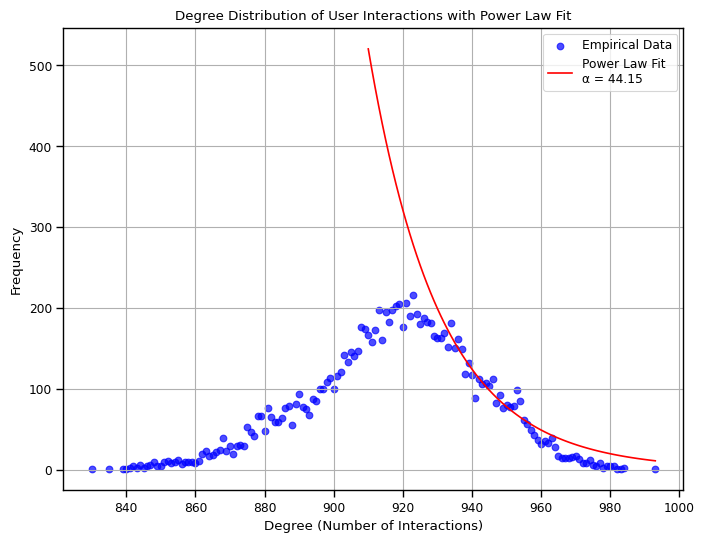

In [27]:
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1


degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

fit = powerlaw.Fit(degree_sequence, xmin=910)  

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin


xmin_int = int(np.floor(xmin))  
x_range = range(xmin_int, max(degrees) + 1)


y_range = [fit.power_law.pdf(x) * len(degree_sequence) for x in x_range]


plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7, label='Empirical Data')

plt.plot(x_range, y_range, color='r', label=f'Power Law Fit\nα = {alpha:.2f}')

plt.title('Degree Distribution of User Interactions with Power Law Fit')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## [Configuration Model](ref:https://snap.stanford.edu/snappy/doc/reference/GenConfModel1.html?highlight=conf)

In [18]:
G_conf_model = snap.GenConfModel(G)

res_conf_model = get_general_characteristics(G_conf_model)
print(res_conf_model)

res_conf_model = get_degree_centrality(G_conf_model)
print(res_conf_model)

res_conf_model = get_closeness_centrality(G_conf_model)
print(res_conf_model)

res_conf_model = get_farness_centrality(G_conf_model)
print(res_conf_model)

res_conf_model = get_eigenvector_centrality(G_conf_model)
print(res_conf_model)

res_conf_model = get_path_length_diameter(G_conf_model)
print(res_conf_model)

res_conf_model = get_innermos_k_shell(G_conf_model)
print(res_conf_model)

res_conf_model = get_cluster_coeff(G_conf_model)
print(res_conf_model)


 configuration model: iter 43659: edges: 43633, left: 85677
   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44466
    Density             : 0.24675032609184547
    Average Degree      : 0.0007387985685790193
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has degre

In [28]:
G_conf_model = snap.GenConfModel(G)

degree_sequence = []
for NI in G_conf_model.Nodes():
    degree_sequence.append(NI.GetDeg())

 configuration model: iter 43659: edges: 43634, left: 85677


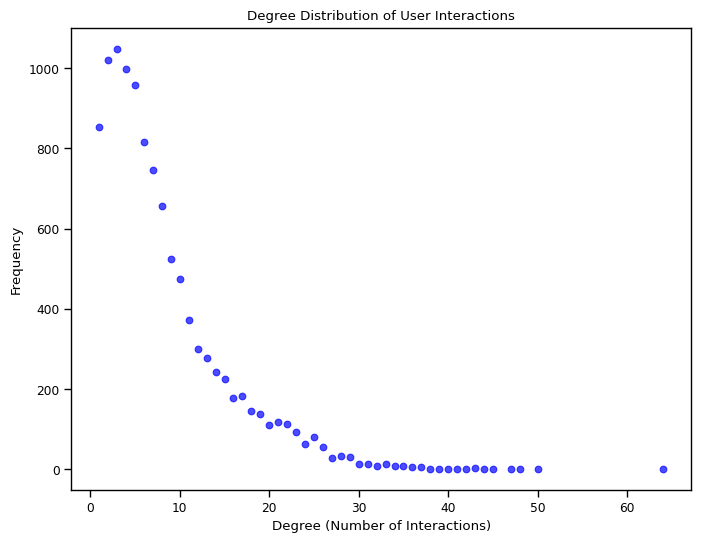

In [29]:
# Count frequency of each degree
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1

# Prepare data for plotting (degree vs frequency)
degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

# Plot the degree distribution as points
plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7)
plt.title('Degree Distribution of User Interactions')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.show()

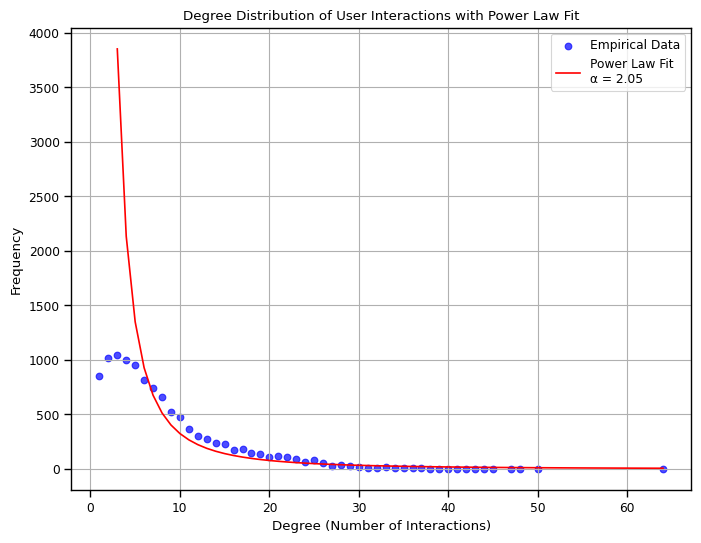

In [30]:
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1


degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

fit = powerlaw.Fit(degree_sequence, xmin=3)  

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin


xmin_int = int(np.floor(xmin))  
x_range = range(xmin_int, max(degrees) + 1)


y_range = [fit.power_law.pdf(x) * len(degree_sequence) for x in x_range]


plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7, label='Empirical Data')

plt.plot(x_range, y_range, color='r', label=f'Power Law Fit\nα = {alpha:.2f}')

plt.title('Degree Distribution of User Interactions with Power Law Fit')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## [Node Rewiring Model](ref:)

In [19]:
G_rewired = snap.GenRewire(G, 100, random)

res_rewired = get_general_characteristics(G_rewired)
print(res_rewired)

res_rewired = get_degree_centrality(G_rewired)
print(res_rewired)

res_rewired = get_closeness_centrality(G_rewired)
print(res_rewired)

res_rewired = get_farness_centrality(G_rewired)
print(res_rewired)

res_rewired = get_eigenvector_centrality(G_rewired)
print(res_rewired)

res_rewired = get_path_length_diameter(G_rewired)
print(res_rewired)

res_rewired = get_innermos_k_shell(G_rewired)
print(res_rewired)

res_rewired = get_cluster_coeff(G_rewired)
print(res_rewired)


Randomizing edges (10972, 44516)...
  5653k/8903k: 2   skip [1.41s]
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.24647317818312517
    Average Degree      : 0.0007396293140571141
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    
  total 8903k switchings attempted, 37k skiped  [2.20s]
   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ------------------------------

In [31]:
G_rewired = snap.GenRewire(G, 100, random)

degree_sequence = []
for NI in G_rewired.Nodes():
    degree_sequence.append(NI.GetDeg())

Randomizing edges (10972, 44516)...
  total 8903k switchings attempted, 37k skiped  [3.68s]


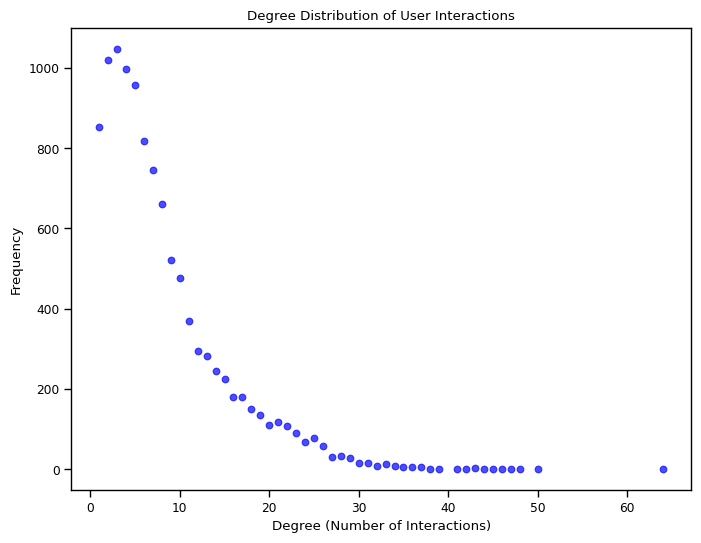

In [32]:
# Count frequency of each degree
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1

# Prepare data for plotting (degree vs frequency)
degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

# Plot the degree distribution as points
plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7)
plt.title('Degree Distribution of User Interactions')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.show()

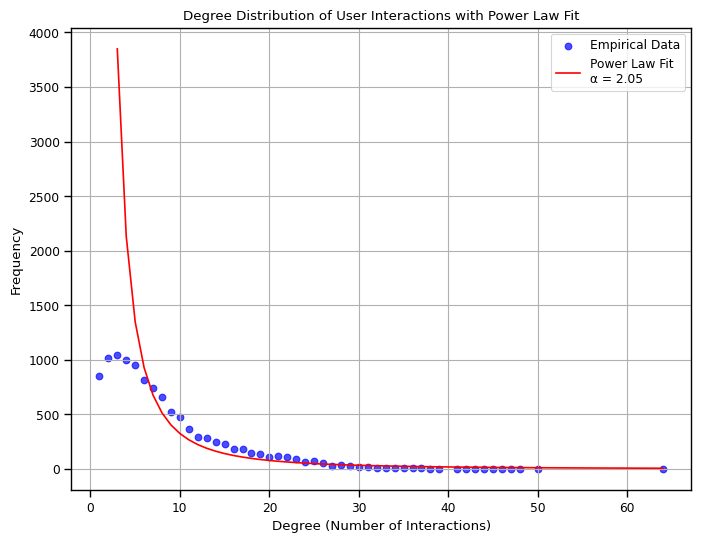

In [33]:
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1


degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

fit = powerlaw.Fit(degree_sequence, xmin=3)  

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin


xmin_int = int(np.floor(xmin))  
x_range = range(xmin_int, max(degrees) + 1)


y_range = [fit.power_law.pdf(x) * len(degree_sequence) for x in x_range]


plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7, label='Empirical Data')

plt.plot(x_range, y_range, color='r', label=f'Power Law Fit\nα = {alpha:.2f}')

plt.title('Degree Distribution of User Interactions with Power Law Fit')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## [Erdos-Reny random graph](href:https://snap.stanford.edu/snappy/doc/reference/GenRndGnm.html?highlight=erdos)

In [75]:
G_ER = snap.GenRewire(G, 100, random)

res_ER = get_general_characteristics(G_ER)
print(res_ER)

res_ER = get_degree_centrality(G_ER)
print(res_ER)

res_ER = get_closeness_centrality(G_ER)
print(res_ER)

res_ER = get_farness_centrality(G_ER)
print(res_ER)

res_ER = get_eigenvector_centrality(G_ER)
print(res_ER)

res_ER = get_path_length_diameter(G_ER)
print(res_ER)

res_ER = get_innermos_k_shell(G_ER)
print(res_ER)

res_ER = get_cluster_coeff(G_ER)
print(res_ER)


Randomizing edges (10972, 44516)...
   413k/8903k: 35k skip [3.40s]
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.24647317818312517
    Average Degree      : 0.0007396293140571141
    Median Degree       : 0.0005468963631391851
    Max Degree          : 0.005833561206817974
    Min Degree          : 9.114939385653085e-05
    ---------------------------------------------------
    
  total 8903k switchings attempted, 37k skiped  [3.57s]
   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ------------------------------

In [34]:
G_ER = snap.GenRewire(G, 100, random)

degree_sequence = []
for NI in G_ER.Nodes():
    degree_sequence.append(NI.GetDeg())

Randomizing edges (10972, 44516)...
  total 8903k switchings attempted, 37k skiped  [3.63s]


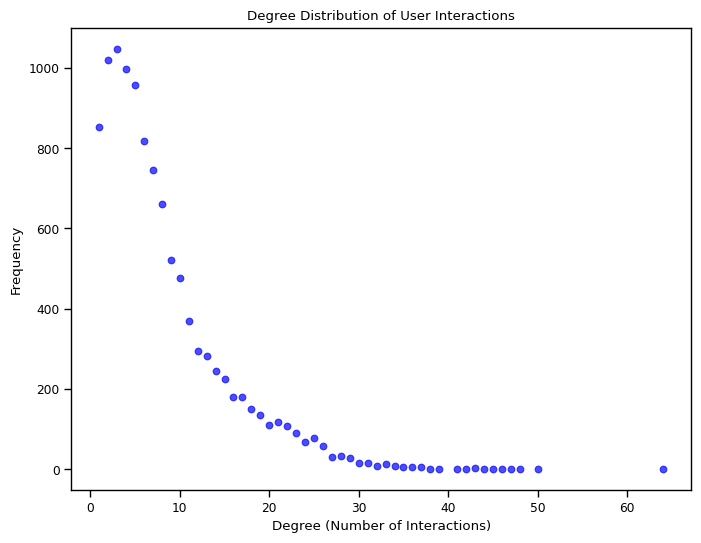

In [35]:
# Count frequency of each degree
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1

# Prepare data for plotting (degree vs frequency)
degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

# Plot the degree distribution as points
plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7)
plt.title('Degree Distribution of User Interactions')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.show()

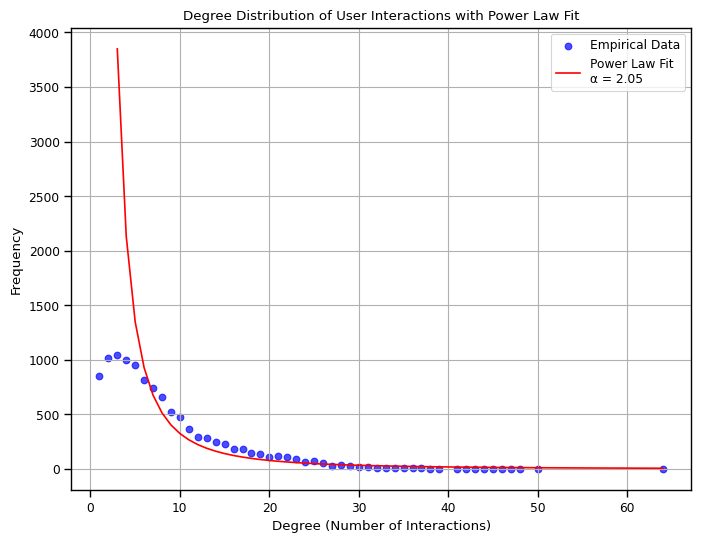

In [36]:
degree_count = {}
for degree in degree_sequence:
    if degree not in degree_count:
        degree_count[degree] = 1
    else:
        degree_count[degree] += 1


degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

fit = powerlaw.Fit(degree_sequence, xmin=3)  

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin


xmin_int = int(np.floor(xmin))  
x_range = range(xmin_int, max(degrees) + 1)


y_range = [fit.power_law.pdf(x) * len(degree_sequence) for x in x_range]


plt.figure(figsize=(8, 6))
plt.scatter(degrees, frequencies, color='b', alpha=0.7, label='Empirical Data')

plt.plot(x_range, y_range, color='r', label=f'Power Law Fit\nα = {alpha:.2f}')

plt.title('Degree Distribution of User Interactions with Power Law Fit')
plt.xlabel('Degree (Number of Interactions)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Others

In [ ]:
# ### Face-to-face contact distribution per day

# df['date'] = df['contact_time'].dt.date

# contact_counts = df.groupby('date').size()

# plt.figure(dpi=150)
# sns.barplot(contact_counts, color='skyblue')

# plt.xlabel('Date')
# plt.ylabel('Number of Face-to-Face Interactions Per Day')
# plt.title('Interactions Per Day')

# plt.xticks(rotation=-45)


# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10)) 

# plt.tight_layout() 
# plt.show()
